# Forecasting solar flares using recurring neural networks for multi-class classification
***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, roc_auc_score,
                             precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score, multilabel_confusion_matrix)

import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input

#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit RNN
***

In [3]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [4]:
# Analyze flare distribution over time

# Number of flare-days per year
df_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum'])
print(df_flares)

        sum
DATE       
2010    8.0
2011   65.0
2012   79.0
2013   68.0
2014  118.0
2015   68.0
2016   11.0
2017   15.0
2018    0.0
2019    0.0
2020    2.0
2021   21.0
2022   92.0
2023    8.0


In [5]:
# Number of days with flares (count should be 8760 [24*365] or 8784 for leap years)
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with flare distribution by year:")
print(yearly_flares)


Days with flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [6]:
# Function for the multi-class feature

def encode_multilabel_from_counts(df):
    """
    df: dataframe with columns ['Flares: C', 'Flares: M', 'Flares: X'] containing integer flare counts per day.
    returns: numpy array (N, 3) with binary indicators for each class.
    order: [Flares: C, Flares: M, Flares: X]
    """

    y = np.zeros((len(df), 3), dtype=np.float32)

    y[:, 0] = (df['Flares: C'].values > 0).astype(float)
    y[:, 1] = (df['Flares: M'].values > 0).astype(float)
    y[:, 2] = (df['Flares: X'].values > 0).astype(float)

    return y

df["flare_classes"] = encode_multilabel_from_counts(df).tolist()

print(df["flare_classes"].shape)
print(df["flare_classes"][0])
print(df["flare_classes"].head())
print(df.info())

(4480,)
[1.0, 0.0, 0.0]
0    [1.0, 0.0, 0.0]
1    [0.0, 0.0, 0.0]
2    [0.0, 0.0, 0.0]
3    [1.0, 0.0, 0.0]
4    [1.0, 1.0, 0.0]
Name: flare_classes, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 n

In [7]:
# Shift target upward by 1 day
df["flare_classes"] = df["flare_classes"].shift(-1)

# Drop the last row (target is NaN)
df = df.dropna(subset=["flare_classes"])

In [8]:
# The dataset is too big to run the hyperparameter opitmization in my PC, so I am going to use a sample for this part
df_short = df.sample(frac=1.00)
print(df_short.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4479 entries, 541 to 11
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4479 non-null   datetime64[ns, UTC]
 1   USFLUX                      4479 non-null   float64            
 2   MEANGAM                     4479 non-null   float64            
 3   MEANGBT                     4479 non-null   float64            
 4   MEANGBZ                     4479 non-null   float64            
 5   MEANGBH                     4479 non-null   float64            
 6   MEANJZD                     4479 non-null   float64            
 7   TOTUSJZ                     4479 non-null   float64            
 8   MEANALP                     4479 non-null   float64            
 9   MEANJZH                     4479 non-null   float64            
 10  TOTUSJH                     4479 non-null   float64            
 

In [9]:
# chronological split is important for time series
df_short = df_short.sort_values('DATE').reset_index(drop=True)
assert df_short['DATE'].is_monotonic_increasing

print(df_short.head())

                       DATE        USFLUX    MEANGAM     MEANGBT     MEANGBZ  \
0 2010-05-01 00:00:00+00:00  2.325578e+21  29.580376  121.361911  123.196711   
1 2010-05-02 00:00:00+00:00  2.699988e+21  28.754651  122.189762  122.241274   
2 2010-05-03 00:00:00+00:00  2.737004e+21  32.654695  114.207593  116.857353   
3 2010-05-04 00:00:00+00:00  3.460735e+21  29.845298  111.707230  113.253585   
4 2010-05-05 00:00:00+00:00  4.497098e+21  32.732238  114.995095  116.684410   

     MEANGBH   MEANJZD       TOTUSJZ   MEANALP   MEANJZH  ...  \
0  51.438868  0.322770  2.560842e+12 -0.003638 -0.001203  ...   
1  49.093493  0.482670  2.708962e+12 -0.007883 -0.001898  ...   
2  50.317212  0.219577  3.095129e+12 -0.002852 -0.000701  ...   
3  47.297438  0.145063  3.903967e+12 -0.015477 -0.005461  ...   
4  53.376813  0.285346  5.270056e+12 -0.019851 -0.008012  ...   

   Radio Flux 10.7cm  Sunspot Number  Sunspot Area (10^6 Hemis.)  New Regions  \
0               78.0            13.0           

In [10]:
# let's check all columns to drop some on the next step
print(df_short.columns)

Index(['DATE', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'R_VALUE', 'xrs_A_mean',
       'xrs_A_min', 'xrs_A_max', 'xrs_B_mean', 'xrs_B_min', 'xrs_B_max',
       'Radio Flux 10.7cm', 'Sunspot Number', 'Sunspot Area (10^6 Hemis.)',
       'New Regions', 'Flares: C', 'Flares: M', 'Flares: X', 'flare_today',
       'flare_missing', 'flare_classes'],
      dtype='object')


# Fitting the model
***

In [11]:
# Build sequences (last N days) and separate features and target

def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

values = df.drop(columns=['DATE', "flare_classes", "flare_today", "flare_missing"]).values
targets = df["flare_classes"].values

seq_len = 3
X_seq, y_seq = create_sequences(values, targets, seq_len)

print(X_seq.shape, y_seq.shape)
print(y_seq)

(4476, 3, 30) (4476, 3)
[[1. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]]


In [12]:
# Split into train and test sets
# Time series should not be randomly shuffled.

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

"""print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")"""

print(y_train[0:30])

[[1. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [13]:
# Scale features
scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

In [14]:
# Compute class weights for flare class imbalance

class_weights = {}
for i, name in enumerate(["Flares: C", "Flares: M", "Flares: X"]):
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0,1]),
        y=y_seq[:, i]
    )
    class_weights[i] = {0: weights[0], 1: weights[1]}
class_weights

positive_weights = [class_weights[i][1] for i in range(3)]
avg_pos_weight = float(np.mean(positive_weights))

class_weight = {0: 1.0, 1: avg_pos_weight}
class_weight

{0: 1.0, 1: 15.06841618834517}

In [15]:
# you can just load the model if already trained and not run the grid search and best model again
# in that case, do not run the next cells
#best_model = load_model('../data/flares_keras_RNN.keras')

In [16]:
# Simple GRU implementation

n_timesteps = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]   # your 3 features per timestep
n_outputs = y_train.shape[1]           # should be 3 (C, M, X)

def build_model(hp):
    units = hp.Int("units", min_value=16, max_value=128, step=16)
    dropout = hp.Float("dropout", 0.0, 0.5, step=0.1)
    lr = hp.Choice("lr", [1e-4, 3e-4, 1e-3])

    model = Sequential([
        Input(shape=(n_timesteps, n_features)),
        GRU(units, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(n_outputs, activation='sigmoid')   # multilabel output
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="bin_acc"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

In [17]:
# Tune of hyperparameters

n_features = X_train_scaled.shape[2]
n_classes = len(np.unique(y_train))

tuner = kt.RandomSearch(
    build_model,
    objective="val_auc",
    max_trials=10,
    overwrite=True,
    directory="tuner",
    project_name="flares"
)

stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [18]:
print("seq_len:", seq_len) # 14 sequence length (number of days)
print("n_features:", n_features) # 30 number of features after dropping non-feature columns
print("n_classes:", n_classes) # 4 number of flare classes: 0, 1, 2, 3

seq_len: 3
n_features: 30
n_classes: 2


In [19]:
# Run tuner (it may take a while...)

tuner.search(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.2,
    #validation_data=(X_seq_val, y_seq_val),
    class_weight=class_weight,
    verbose=1,
    callbacks=[stop]
)

Trial 10 Complete [00h 00m 09s]
val_auc: 0.8346660137176514

Best val_auc So Far: 0.8576926589012146
Total elapsed time: 00h 01m 56s


In [20]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [21]:
# Train with best model
best_model = tuner.get_best_models(1)[0]

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=40,
    batch_size=64,
    class_weight=class_weight,
    #validation_split=0.1,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True
    )]
)

Epoch 1/40


l:\Git\hbr-solar-forecast-project\ml_env\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9529 - bin_acc: 0.9137 - loss: 0.2464 - precision: 0.8467 - recall: 0.6931
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9538 - bin_acc: 0.9150 - loss: 0.2397 - precision: 0.8487 - recall: 0.6987
Epoch 3/40


l:\Git\hbr-solar-forecast-project\ml_env\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: auc,bin_acc,loss,precision,recall
  current = self.get_monitor_value(logs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9552 - bin_acc: 0.9155 - loss: 0.2374 - precision: 0.8500 - recall: 0.7006
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9560 - bin_acc: 0.9169 - loss: 0.2336 - precision: 0.8500 - recall: 0.7085
Epoch 5/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9576 - bin_acc: 0.9179 - loss: 0.2269 - precision: 0.8444 - recall: 0.7215
Epoch 6/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9572 - bin_acc: 0.9184 - loss: 0.2239 - precision: 0.8476 - recall: 0.7211
Epoch 7/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9577 - bin_acc: 0.9194 - loss: 0.2234 - precision: 0.8503 - recall: 0.7234
Epoch 8/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9581 - bin_acc: 0.9184 - loss: 0.2230 - precision: 0.8438 - recall: 0.7257
Epoch 9/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9590 - bin_acc: 0.9196 - loss: 0.2179 - precision: 0.8524 - recall: 0.7220
Epoch 10/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9601 - bin_ac

In [22]:
# evaluate
results = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(best_model.metrics_names, results)))

{'loss': 0.3925100266933441, 'compile_metrics': 0.8738839030265808}


In [23]:
# Save the best model
best_model.save("../data/flares_keras_RNN.keras")
print("Best model saved to ../data/flares_keras_RNN.keras")

Best model saved to ../data/flares_keras_RNN.keras


In [24]:
# Predict
y_pred_proba = best_model.predict(X_test_scaled).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [25]:
# Predict (do NOT ravel multi-class outputs)
y_pred_proba = best_model.predict(X_test_scaled)   # shape (n_samples, n_classes) for multi-class
if y_pred_proba.ndim > 1:
    # multi-class: take class with highest probability
    y_pred_labels = np.argmax(y_pred_proba, axis=1)
else:
    # binary: threshold the single probability output
    y_pred_labels = (y_pred_proba.ravel() >= 0.5).astype(int)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# Results
***

In [26]:
# quick debug: print shapes
print("len(y_test) =", len(y_test), "len(y_pred_labels) =", len(y_pred_labels))
print("y_test.ndim =", y_test.ndim, "y_pred_labels.ndim =", np.asarray(y_pred_labels).ndim)

len(y_test) = 896 len(y_pred_labels) = 896
y_test.ndim = 2 y_pred_labels.ndim = 1


In [27]:
# Metrics

# 1. Probabilities from NN
y_pred_proba = best_model.predict(X_test)

# 2. Convert to binary labels
y_pred = (y_pred_proba >= 0.5).astype(int)

# 3. Confusion matrix
cm = multilabel_confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 4. Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["C", "M", "X"]))

# 5. Additional metrics
if len(np.unique(y_test)) > 1:

    # average="macro"     -> treat each class equally  
    # average="micro"     -> aggregate over all labels  
    # average="weighted"  -> weight by class frequency

    f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    f1 = fbeta_score(y_test, y_pred, beta=1, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    avg_prec = average_precision_score(y_test, y_pred_proba, average=None)
    roc_auc = roc_auc_score(y_test, y_pred_proba, average=None)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2, f1, recall, avg_prec, roc_auc]
    })

    print("\nEvaluation Metrics:")
    #print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Confusion Matrix:
[[[  0 419]
  [  0 477]]

 [[  0 777]
  [  0 119]]

 [[158 726]
  [  0  12]]]

Classification Report:
              precision    recall  f1-score   support

           C       0.53      1.00      0.69       477
           M       0.13      1.00      0.23       119
           X       0.02      1.00      0.03        12

   micro avg       0.24      1.00      0.39       608
   macro avg       0.23      1.00      0.32       608
weighted avg       0.44      1.00      0.59       608
 samples avg       0.23      0.54      0.31       608


Evaluation Metrics:


l:\Git\hbr-solar-forecast-project\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Visualization saved as 'solar_flare_RNN_results.png'


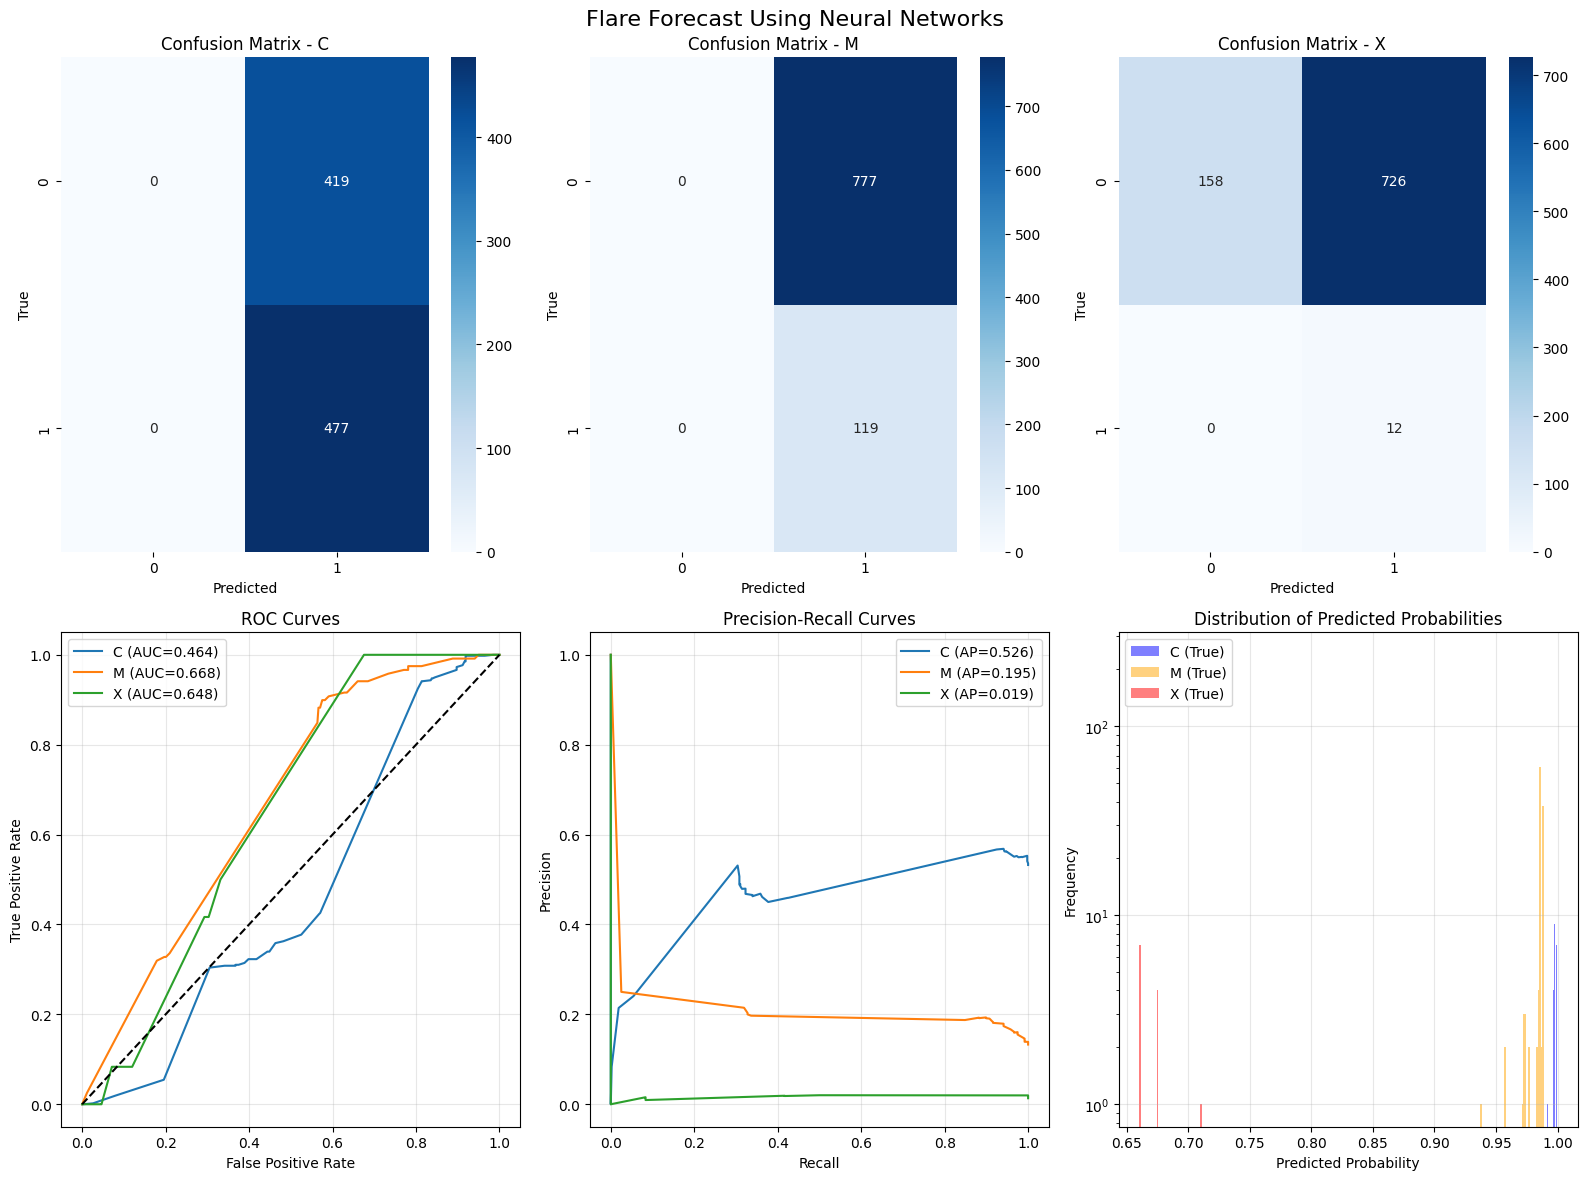

In [28]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Neural Networks', fontsize=16)

labels = ["C", "M", "X"]

# --- Confusion matrices ---
for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues",
                xticklabels=["0","1"], yticklabels=["0","1"], ax=ax)
    ax.set_title(f"Confusion Matrix - {labels[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# --- ROC Curves ---
ax = plt.subplot(2, 3, 4)

from sklearn.metrics import roc_curve, auc

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    ax.plot(fpr, tpr, label=f"{labels[i]} (AUC={auc(fpr, tpr):.3f})")

ax.plot([0, 1], [0, 1], "k--")
ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
ax.grid(True, alpha=0.3)

# --- Precision-Recall Curves ---
ax = plt.subplot(2, 3, 5)

for i in range(3):
    prec, rec, _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_test[:, i], y_pred_proba[:, i])
    ax.plot(rec, prec, label=f"{labels[i]} (AP={ap:.3f})")

ax.set_title("Precision-Recall Curves")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
ax.grid(True, alpha=0.3)

# --- Predicted Probabilities Distribution ---
ax = plt.subplot(2, 3, 6)

colors = ["blue", "orange", "red"]

for i in range(3):
    ax.hist(
        y_pred_proba[y_test[:, i] == 1, i],
        bins=40, alpha=0.5,
        color=colors[i],
        label=f"{labels[i]} (True)"
    )

ax.set_title("Distribution of Predicted Probabilities")
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Frequency")
ax.set_yscale("log")
ax.legend()
ax.grid(True, alpha=0.3)

# Save and show figure
plt.tight_layout()
plt.savefig('../figures/solar_flare_RNN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_RNN_results.png'")
plt.show()

In [29]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([ 158, 2530]))

In [30]:
y_pred_proba[:10]

array([[0.9992148 , 0.9887689 , 0.6751809 ],
       [0.99837863, 0.97338873, 0.6475539 ],
       [0.99837863, 0.97338873, 0.6475539 ],
       [0.9974353 , 0.9761644 , 0.6915838 ],
       [0.99851036, 0.9736911 , 0.71097434],
       [0.99851036, 0.9736911 , 0.71097434],
       [0.99851036, 0.9736911 , 0.71097434],
       [0.9974353 , 0.9761644 , 0.6915838 ],
       [0.99837863, 0.97338873, 0.6475539 ],
       [0.9986553 , 0.9876482 , 0.7733819 ]], dtype=float32)